In [2]:

import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
import pytz
from datetime import datetime, timedelta

import optimizer.s3 as s3u
import evaluation.eval_framework as efu

import pickle

In [3]:
def get_historical_fcst_data_cached(plug_in_time, horizon, region):
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    date = plug_in_time.date()
    if (region, date) not in HISTORICAL_FORECAST_CACHE.keys():
        print(type(date), date)
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("1d"))      
        HISTORICAL_FORECAST_CACHE[(region, date)] = hist_data.get_historical_forecast_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_FORECAST_CACHE[(region, date)]
        
    # make this match efu.get_historical_fsct_data
    generated_at_times = cache["generated_at"].unique()
    generated_at = max([t for t in generated_at_times if t < plug_in_time_utc])
    df = cache[cache["generated_at"] == generated_at].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12]

def get_historical_actual_data_cached(plug_in_time, horizon, region):
    time_zone = efu.get_timezone_from_dict(region)
    plug_in_time_utc = pd.Timestamp(efu.convert_to_utc(plug_in_time, time_zone))
    date = plug_in_time.date()
    
    if (region, date) not in HISTORICAL_ACTUAL_CACHE.keys():
        start = pd.to_datetime(date)
        end = (pd.to_datetime(date) + pd.Timedelta("2d"))   
        HISTORICAL_ACTUAL_CACHE[(region, date)] = actual_data.get_historical_pandas(
            start - pd.Timedelta("9h"),
            end + pd.Timedelta("9h"),
            region,
        )
    cache = HISTORICAL_ACTUAL_CACHE[(region, date)]

    t_start = max([t for t in cache["point_time"].unique() if t < plug_in_time_utc])
    df =  cache[cache["point_time"] >= t_start].copy()
    return df.iloc[:math.ceil(horizon / 12) * 12 + 1].reset_index(drop=True)

def get_total_emission(moer, schedule):
    x = np.array(schedule).flatten()
    return np.dot(moer[:x.shape[0]], x)


In [5]:
# cached watttime data
s3 = s3u.s3_utils()

actual_pickle = s3.load_file(file="pjm_actual.pkl")
HISTORICAL_ACTUAL_CACHE = pickle.loads(actual_pickle)

forecast_pickle = s3.load_file(file="pjm_forecast.pkl")
HISTORICAL_FORECAST_CACHE = pickle.loads(actual_pickle)

In [6]:
# 10 synthetic data examples

key = '20240726_1k_synth_users_163_days.csv'
generated_data = s3.load_csvdataframe(file=key)
generated_data = generated_data[-10:]

synth_data = generated_data.copy(deep=True)

synth_data["plug_in_time"] = pd.to_datetime(synth_data["plug_in_time"])
synth_data["unplug_time"] = pd.to_datetime(synth_data["unplug_time"])

In [ ]:
synth_data[["plug_in_time","total_intervals_plugged_in"]]

In [10]:
region = "PJM_CHICAGO"

synth_data['moer_data'] = synth_data.apply(
    lambda x: efu.get_historical_fcst_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

In [11]:
synth_data['moer_data_actual'] = synth_data.apply(
    lambda x: efu.get_historical_actual_data(
    x.plug_in_time,
    math.ceil(x.total_intervals_plugged_in),
    region = region
    ), axis = 1
)

## API on "NEW" optCharger
- `power_output_rate` is a float and the input to `usage_power_kw`
- input `usage_time_required_minutes` instead of charge

In [155]:
import importlib
importlib.reload(efu)

<module 'evaluation.eval_framework' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/eval_framework.py'>

In [12]:
get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda  x: x["emissions_co2e_lb"].sum()

In [157]:
synth_data['charger_simple_actual_api']= synth_data.apply(
    lambda x: efu.get_schedule_and_cost_v2(
        usage_power_kw = x.power_output_rate,
        total_intervals = math.ceil(x.total_intervals_plugged_in),
        time_needed = int(math.ceil(min(x.total_seconds_to_95, x.length_plugged_in) / 300.0) * 5),
        moer_data = x.moer_data_actual,
        optimization_method='simple'
        ), 
        axis = 1
        )

synth_data['simple_actual_charging_schedule_api'] = synth_data['charger_simple_actual_api'].apply(get_charging_schedule_lambda)
synth_data['simple_ideal_emissions_api'] = synth_data['charger_simple_actual_api'].apply(get_total_emissions_lambda)


In [158]:
synth_data['simple_ideal_emissions_api']

162990    22.540327
162991    26.493110
162992    24.553696
162993    44.976289
162994    39.845758
162995    42.825378
162996    45.899687
162997    31.271836
162998    32.880181
162999    46.702132
Name: simple_ideal_emissions_api, dtype: float64

## NOT API w/ "OLD" optCharger

In [15]:
synth_data['charger_simple_actual'] = synth_data.apply(
    lambda x: efu.get_schedule_and_cost(
        x.MWh_fraction,
        x.charged_kWh_actual / 1000,
        math.ceil(x.total_intervals_plugged_in), # will throw an error if the plug in time is too shart to reach full charge, should soften to a warning
        x.moer_data_actual,
        asap = False
        ), 
        axis = 1
        )

In [16]:
synth_data['simple_actual_charging_schedule'] = synth_data['charger_simple_actual'].apply(
    lambda  x: x.get_schedule()
    )

synth_data['simple_ideal_emissions'] = synth_data['charger_simple_actual'].apply(
    lambda  x: x.get_total_emission()
    )

## Compare

<Axes: >

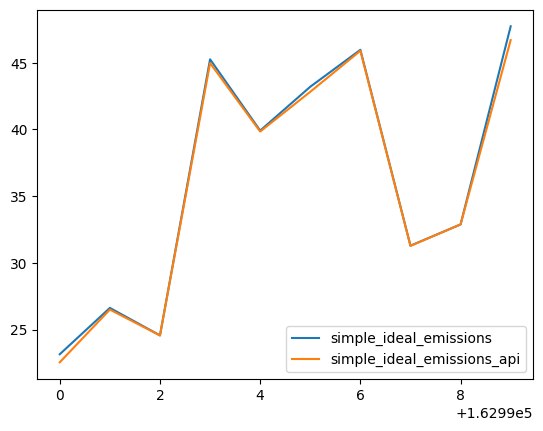

In [159]:
# very very close
synth_data[['simple_ideal_emissions','simple_ideal_emissions_api']].plot(kind='line')

### producing different schedules

In [160]:
ind_x = 4

In [165]:
synth_data['simple_actual_charging_schedule'].iloc[ind_x][-10:]

[0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0.0006911666666666,
 0]

In [166]:
synth_data['simple_actual_charging_schedule_api'].iloc[ind_x].tolist()[-10:]

[5.0, 0.0, 5.0, 5.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0]

### Also different lengths
- it's always the old method where the length varies, the new method matches the length of the input MOER values
- real issue is that the usage windows don't match.

In [167]:
len(synth_data['simple_actual_charging_schedule'].iloc[ind_x])

104

In [168]:
len(synth_data['simple_actual_charging_schedule_api'].iloc[ind_x].tolist())

109

In [169]:
# there are 109 values from start to end.
synth_data.moer_data_actual.iloc[ind_x]["point_time"].shape

(109,)